In [2]:
# carregando dataset
from sklearn.datasets import load_iris
dataset = load_iris()
X, y = dataset.data[:,2:], dataset.target
X.shape, y.shape

((150, 2), (150,))

In [21]:
import matplotlib.pyplot as plt 
import numpy as np 

def plot_region(model, X, y):
    model.fit(X, y)
    X0, X1 = X[:, 0], X[:,1]
    x0s = np.linspace(np.min(X0)-0.2, np.max(X0)+0.2,100)
    x1s = np.linspace(np.min(X1)-0.2, np.max(X1)+0.2,100)

    x0, x1 = np.meshgrid(x0s, x1s)
    x_decision = np.c_[x0.ravel(), x1.ravel()]

    yprediction = model.predict(x_decision)

    plt.contourf(x0, x1, yprediction.reshape(x0.shape), alpha=0.2)
    for value in set(y):
        plt.plot(X0[y==value], X1[y==value], 'o', label=f"{dataset.target_names[value]}")
    plt.xlabel(f"X[0]: {dataset.feature_names[0]}")
    plt.ylabel(f"X[1]: {dataset.feature_names[1]}")
    plt.show()


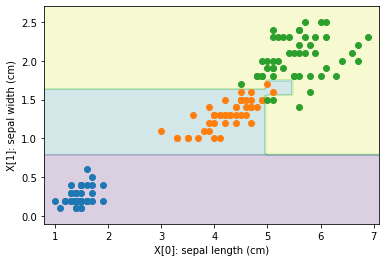

In [22]:
from sklearn.tree import DecisionTreeClassifier
plot_region(DecisionTreeClassifier(), X, y)